In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

%matplotlib inline

113498
Total "observations": 113198
Observations with data: 54978
Sponsored observations: 15
4200000 4313196


,category,author,published,shares,sponsored,comments,time,title,article_id
0,wires,Reuters,"\n ,\n 09:26 EDT, 7 February 2017\n",NaN,NaN,NaN,2017-03-14 23:31:41.584110,Russia says Trump's efforts on Ukraine better ...,4200006
9,wires,Reuters,"\n ,\n 10:20 EDT, 7 February 2017\n",NaN,NaN,NaN,2017-03-14 23:31:41.678891,Eurogroup's Dijsselbloem sees no forgiveness o...,4200040
24,wires,Reuters,"\n ,\n 09:39 EDT, 7 February 2017\n",NaN,NaN,NaN,2017-03-14 23:31:41.792692,Polish PM says determined to deepen cooperatio...,4200036


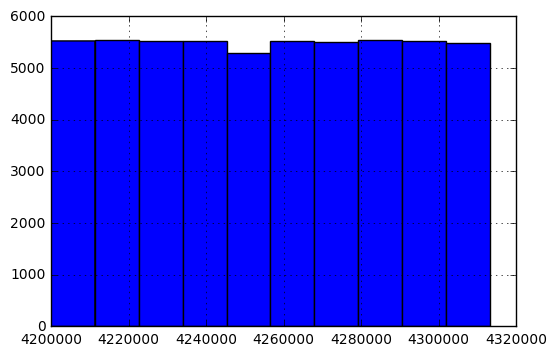

In [2]:
df = pd.read_csv('dm_4200000_4313498.csv')
#df = pd.read_csv('dm_2200000_4200000.csv', low_memory=False)

print 4313498 - 4200000 ## took 43min
print 'Total "observations":', len(df)
df = df.loc[df['flag'] == 'found']
df = df.drop('flag', 1)
print 'Observations with data:', len(df)
print 'Sponsored observations:', len(df[df['sponsored'].notnull()])

print df['article_id'].min(), df['article_id'].max()
id_hist = df['article_id'].hist()
id_hist

df.head(3)

### Convert time columns to datetime format

In [3]:
# Convert 'time' and 'pd_time' to datetime format
df['time'] = pd.to_datetime(df['time'])

# Convert 'published to datetime format
def month_converter(month):
    months = ['None', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
              'September', 'Octover', 'November', 'December']
    return months.index(month)

df['published'] = df['published'].str.replace('\n','').str.replace(',','').str.lstrip(' ')
df_pub_1 = df[df['published'].notnull()]
df_pub_2  = pd.DataFrame(df_pub_1['published'].str.split(' ').tolist(),
                       columns=['time','EDT','day','month','year','None']).ix[:,:5]
df_pub = pd.concat([df_pub_2.reset_index(drop=True), df_pub_1[['article_id']].reset_index(drop=True)], 1)
df_pub['hour'] = pd.DataFrame(df_pub['time'].str.split(':').tolist()).ix[:,0]
df_pub['minute'] = pd.DataFrame(df_pub['time'].str.split(':').tolist()).ix[:,1]
df_pub['month'] = df_pub['month'].apply(month_converter)
df_pub['pub_time'] = pd.to_datetime(df_pub[['year','month','day','hour','minute']])
df_pub = df_pub[['article_id','pub_time']]

df = df.merge(df_pub, 'left', 'article_id')
del df_pub, df_pub_1, df_pub_2
df.drop('published', axis=1, inplace=True)   # uncomment to check it's working
df.head(5)

,category,author,shares,sponsored,comments,time,title,article_id,pub_time
0,wires,Reuters,NaN,NaN,NaN,2017-03-14 23:31:41.584110,Russia says Trump's efforts on Ukraine better ...,4200006,2017-02-07 09:26:00
1,wires,Reuters,NaN,NaN,NaN,2017-03-14 23:31:41.678891,Eurogroup's Dijsselbloem sees no forgiveness o...,4200040,2017-02-07 10:20:00
2,wires,Reuters,NaN,NaN,NaN,2017-03-14 23:31:41.792692,Polish PM says determined to deepen cooperatio...,4200036,2017-02-07 09:39:00
3,wires,Associated Press,NaN,NaN,NaN,2017-03-14 23:31:41.852959,Jovenel Moise sworn in as Haiti's new president,4200054,2017-02-07 18:04:00
4,wires,Afp,NaN,NaN,NaN,2017-03-14 23:31:41.953421,US 2016 trade deficit highest in four years,4200030,2017-02-07 10:27:00


### Create date/time features

For the date, a [post on CrossValidated](http://stats.stackexchange.com/questions/65900/does-it-make-sense-to-use-a-date-variable-in-a-regression) suggests including time from an origin within the time period of study or very close to it. 

In [4]:
# Date since start of data
df['pub_days'] = (df['pub_time'] - min(df['pub_time'])).dt.days

# Day of week
df['pub_dayofweek'] = df['pub_time'].dt.weekday

# Minutes since midnight
def min_since_midnight(t):
    res = (t.hour * 3600) + (t.minute * 60) + t.second + (t.microsecond / 1000000.0)
    return(res)
df['pub_sincemid'] = df.pub_time.apply(min_since_midnight)

### Convert shared and comments variables to numeric

In [5]:
def shift_dec(number):
    if "." in number:
        number = number[:-1].replace('.','')
    return number

for x in ['shares','comments']:
    df[x] = df[x].str.strip()
    df[x].fillna(0, inplace=True)
    df[x] = df[x].apply(str)
    df[x] = df[x].str.replace('k','000')
    df[x] = df[x].apply(shift_dec)
df.head(3)

,category,author,shares,sponsored,comments,time,title,article_id,pub_time,pub_days,pub_dayofweek,pub_sincemid
0,wires,Reuters,0,NaN,0,2017-03-14 23:31:41.584110,Russia says Trump's efforts on Ukraine better ...,4200006,2017-02-07 09:26:00,0.0,1.0,33960.0
1,wires,Reuters,0,NaN,0,2017-03-14 23:31:41.678891,Eurogroup's Dijsselbloem sees no forgiveness o...,4200040,2017-02-07 10:20:00,0.0,1.0,37200.0
2,wires,Reuters,0,NaN,0,2017-03-14 23:31:41.792692,Polish PM says determined to deepen cooperatio...,4200036,2017-02-07 09:39:00,0.0,1.0,34740.0


### Create a dummy variable for sponsored content

In [6]:
df['sponsored_dummy'] = 0
df.loc[df.sponsored.notnull(), 'sponsored_dummy'] = 1

In [7]:
df.to_csv('dm_dat.csv')